## 1. Import and Clean Data

In [2]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 49.8 MB/s eta 0:00:00


In [4]:
# import libraries
import fitz
import re
import pandas as pd
import string
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud
import spacy
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
# Reading the script file
doc = fitz.open('everything-everywhere-all-at-once-2022.pdf')
all_text = ""
for page_number in range(len(doc)):
    page = doc[page_number]
    all_text += page.get_text()

# Split the text into lines
lines = all_text.splitlines()
print(lines[:15])  # Preview first 15 lines

['EVERYTHING EVERYWHERE ALL AT ONCE', 'Written by', 'Daniel Kwan and Daniel Scheinert', 'INT. APARTMENT - DINING ROOM/LIVING ROOM - NIGHT', '1', 'A round mirror sitting on a cluttered vanity. Disco lights ', 'flash across the clutter. We hear the opening bars of KARAOKE ', 'MUSIC.', 'BEGIN OPENING CREDITS.  ', 'Through the hazy mirror, we watch as a Chinese family of ', "three, THE WANG's, sing karaoke together.", 'They can\'t agree on a song but they settle on "Barbie Girl" ', "by Aqua. They are awkward and off pitch. But it's sweet. A ", 'brief snapshot of happiness. Then, like a flip of a switch-', 'INT. APARTMENT - DINING ROOM/LIVING ROOM - MORNING']


#### a) Text Preprocessing and Annotation

In [12]:
# RegEx patterns for identifying script elements
character_pattern = re.compile(r'^[A-Z ]+$')  # Character names (all uppercase line)
scene_pattern = re.compile(r'^(INT\.|EXT\.)')  # Scene headers
header_pattern = re.compile(r'^[A-Z]{2}.*') # header (capitalized words)
scene_num = re.compile(r'^\d+$') # scene numbers
sub_scene_num = re.compile(r'^[A-Z]*\d+[-\d]*[a-z]*[/\d]*$')  # Sub-scenes (e.g., 107-1, A107)
page_num = re.compile(r'^\d+\.$') # page numbers (e.g.: 1.)
chinese_pattern = re.compile(r'[\u4e00-\u9fff]+') # chinese characters
title_pattern = re.compile(r'^TITLE: ') # part titles

In [23]:
# extract the universe name from scene header
def extract_universe(header):
    if not header:
        return "UNKNOWN"

    if "VERSE" in header:
        if ":" in header:
            pu = header.split(":")
            if "VERSE" in pu[0]:
              u = pu[0].strip()
            elif "VERSE" in pu[1]:
              pu2 = pu[1].split("-")
              u = pu2[0].strip()
            else:
              u = "UNKNOWN"
        elif "ORIGINAL UNIVERSE" in header:
            u = "ORIGINAL UNIVERSE"
        else:
            u = "UNKNOWN"
    else:
        u = "UNKNOWN"
    return u

# test
a = "FLASH: MOVIE STAR UNIVERSE: the movie premiere audience applauds."
extract_universe(a)

'MOVIE STAR UNIVERSE'

Create a dataframe with each scene/subscene as a row

In [13]:
# Initialize variables
scenes = []
previous_line = ''
part_i = 0
part_titles = ['PART 1: EVERYTHING', 'PART 2: EVERYWHERE', 'PART 3: ALL AT ONCE']
universe = "ORIGINAL UNIVERSE"
current_scene_num = None
current_scene = {"part": '', "scene": '', "sub-scene": '', "universe": '', "header": None, "content": []}


for line in lines:
    line = line.strip()

    # New scene number
    if scene_num.match(line):
        if current_scene["header"]:
            current_scene["content"].pop()  # remove header from content
            current_scene["content"] = "".join(current_scene["content"]).strip() # join previous scene content into a string
            scenes.append(current_scene) # Save the previous scene

        # universe
            if extract_universe(previous_line) != "UNKNOWN": # update universe name when new universe is specified, otherwise stays the same
              universe = extract_universe(previous_line)

        # Start a new scene
        current_scene = {"part": part_titles[part_i],
                         "scene": line,
                         "sub-scene": '',
                         "universe": universe,
                         "header": previous_line,
                         "content": []}
        current_scene_num = line

    # new subscene number
    elif sub_scene_num.match(line):
        if current_scene["header"]:  # Save the previous scene
            current_scene["content"].pop()  # remove header from previous scene content
            current_scene["content"] = "".join(current_scene["content"]).strip() # join previous scene content into a string
            scenes.append(current_scene)

            # universe
            if extract_universe(previous_line) != "UNKNOWN": # update universe name when new universe is specified, otherwise stays the same
              universe = extract_universe(previous_line)
        # Start a new scene
        current_scene = {"part": part_titles[part_i],
                         "scene": current_scene_num,
                         "sub-scene": line,
                         "universe": universe,
                         "header": previous_line,
                         "content": []}

    # continuing scene
    else:
        # skip the line if it's a page number
        if page_num.match(line):
            continue
        # skip the line if it's Chinese and delete the previous line (character name)
        elif chinese_pattern.search(line):
            if character_pattern.match(previous_line):  # Check if the previous line is a character name
                # remove the previous line
                if current_scene["content"] != []:
                    current_scene["content"].pop()
            else:
                continue

        # check part titles
        elif title_pattern.match(line):
            if part_i < 2:
                part_i += 1


        # add the current line to the content
        else:
            current_scene["content"].append(" " + line)


    # store line as previous line
    previous_line = line


# Add the last scene
if current_scene:
    current_scene["content"] = "".join(current_scene["content"]).strip() # join content into string
    scenes.append(current_scene)

#scenes["content"] = "".join(scenes["content"]).strip() # join content into string


scenes[0]

{'part': 'PART 1: EVERYTHING',
 'scene': '1',
 'sub-scene': '',
 'universe': 'ORIGINAL UNIVERSE',
 'header': 'INT. APARTMENT - DINING ROOM/LIVING ROOM - NIGHT',
 'content': 'A round mirror sitting on a cluttered vanity. Disco lights flash across the clutter. We hear the opening bars of KARAOKE MUSIC. BEGIN OPENING CREDITS. Through the hazy mirror, we watch as a Chinese family of three, THE WANG\'s, sing karaoke together. They can\'t agree on a song but they settle on "Barbie Girl" by Aqua. They are awkward and off pitch. But it\'s sweet. A brief snapshot of happiness. Then, like a flip of a switch-'}

In [20]:
# Convert to a DataFrame
df = pd.DataFrame(scenes)
df.head(10)

,part,scene,sub-scene,universe,header,content
0,PART 1: EVERYTHING,1,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - NIGHT,A round mirror sitting on a cluttered vanity. ...
1,PART 1: EVERYTHING,2,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - MOR...,"SNAP. EVELYN WANG bursts into the room, a 55 y..."
2,PART 1: EVERYTHING,2,2-1,ORIGINAL UNIVERSE,A BUZZER. Evelyn turns to the security feed an...,girls waving at the camera. The MICROWAVE BEEP...
3,PART 1: EVERYTHING,3,,ORIGINAL UNIVERSE,INT. LAUNDROMAT - THAT MOMENT,"Waiting by a door, JOY WANG - 20's, sporting a..."
4,PART 1: EVERYTHING,4,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - THA...,Evelyn comes running up the stairs. Waymond is...
5,PART 1: EVERYTHING,4,4-1,ORIGINAL UNIVERSE,A BUZZER goes off. Evelyn looks up at the secu...,see a customer is waiting downstairs at the co...
6,PART 1: EVERYTHING,5,,ORIGINAL UNIVERSE,INT. APARTMENT - STAIRCASE - CONTINUOUS,Evelyn rushes down the stairs with Joy followi...
7,PART 1: EVERYTHING,6,,ORIGINAL UNIVERSE,INT. LAUNDROMAT - CONTINUOUS,Evelyn weaves through laundry carts and custom...
8,PART 1: EVERYTHING,7,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - MOM...,Evelyn and Joy re-enter the apartment. Hanging...
9,PART 1: EVERYTHING,7,7-1,ORIGINAL UNIVERSE,"Meanwhile, in the security camera feed we see ...",fall forward then lift up again. He looks arou...


Take a look at all universes

In [15]:
df['universe'].value_counts()

,count
universe,
ORIGINAL UNIVERSE,58
ALPHAVERSE,49
TAXES UNIVERSE,39
ACTION UNIVERSE,36
MOVIE STAR UNIVERSE,24
VARIOUS UNIVERSES,17
CHEF UNIVERSE,13
TEMPLE UNIVERSE,11
HOT DOG UNIVERSE,10


#### b) Tokenization, Lemmatization, and Stop Words Removal

In [16]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm") # Load spaCy's English model

In [24]:
# define a function to tokenize and lemmatize texts
def textClean(t):
  doc = nlp(t)
  # Tokenization, Remove stop words, punctuation, and non-alphanumeric tokens
  tokens = [token for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
  # lemmatization
  lemmas = [token.lemma_.lower() for token in tokens]
  return(lemmas)

df["clean_content"] = df["content"].map(textClean)
df.head(10)

,part,scene,sub-scene,universe,header,content,clean_content
0,PART 1: EVERYTHING,1,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - NIGHT,A round mirror sitting on a cluttered vanity. ...,"[round, mirror, sit, cluttered, vanity, disco,..."
1,PART 1: EVERYTHING,2,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - MOR...,"SNAP. EVELYN WANG bursts into the room, a 55 y...","[snap, evelyn, wang, burst, room, year, old, c..."
2,PART 1: EVERYTHING,2,2-1,ORIGINAL UNIVERSE,A BUZZER. Evelyn turns to the security feed an...,girls waving at the camera. The MICROWAVE BEEP...,"[girl, wave, camera, microwave, beeps, evelyn,..."
3,PART 1: EVERYTHING,3,,ORIGINAL UNIVERSE,INT. LAUNDROMAT - THAT MOMENT,"Waiting by a door, JOY WANG - 20's, sporting a...","[wait, door, joy, wang, sport, worn, hoodie, s..."
4,PART 1: EVERYTHING,4,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - THA...,Evelyn comes running up the stairs. Waymond is...,"[evelyn, come, run, stair, waymond, halfway, s..."
5,PART 1: EVERYTHING,4,4-1,ORIGINAL UNIVERSE,A BUZZER goes off. Evelyn looks up at the secu...,see a customer is waiting downstairs at the co...,"[customer, wait, downstairs, counter, evelyn, ..."
6,PART 1: EVERYTHING,5,,ORIGINAL UNIVERSE,INT. APARTMENT - STAIRCASE - CONTINUOUS,Evelyn rushes down the stairs with Joy followi...,"[evelyn, rush, stair, joy, follow, joy, mom, w..."
7,PART 1: EVERYTHING,6,,ORIGINAL UNIVERSE,INT. LAUNDROMAT - CONTINUOUS,Evelyn weaves through laundry carts and custom...,"[evelyn, weave, laundry, cart, customer, evely..."
8,PART 1: EVERYTHING,7,,ORIGINAL UNIVERSE,INT. APARTMENT - DINING ROOM/LIVING ROOM - MOM...,Evelyn and Joy re-enter the apartment. Hanging...,"[evelyn, joy, enter, apartment, hang, precario..."
9,PART 1: EVERYTHING,7,7-1,ORIGINAL UNIVERSE,"Meanwhile, in the security camera feed we see ...",fall forward then lift up again. He looks arou...,"[fall, forward, lift, look, store, suddenly, a..."


#### c) Top words

In [25]:
# list of all tokens
all_tokens = [token for tokens in df['clean_content'] for token in tokens]
len(all_tokens)

12192

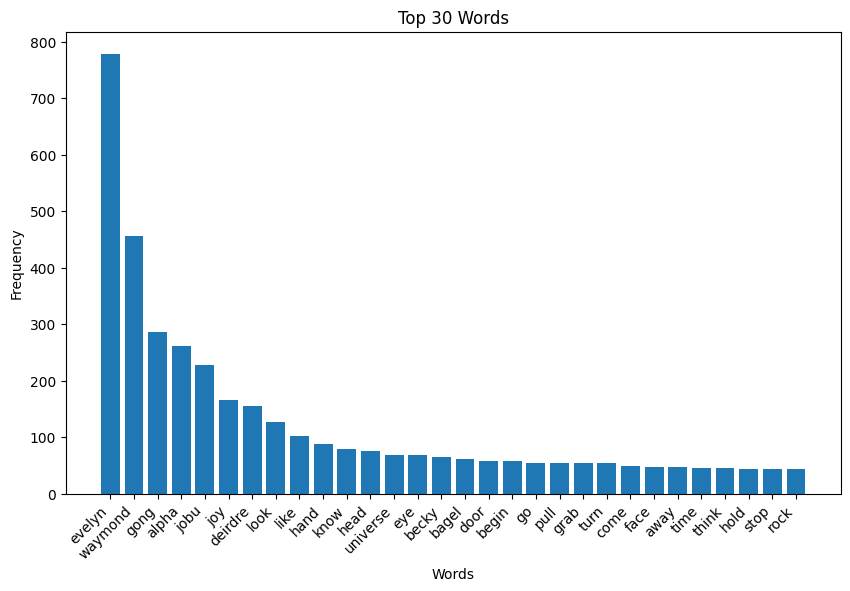

In [26]:
word_counts = Counter(all_tokens)
top_words = word_counts.most_common(30) # top 30 words
# define a function to plot words vs. frequency
def plot_words(top_words):
  words, frequencies = zip(*top_words)
  plt.figure(figsize=(10, 6))
  plt.bar(words, frequencies)
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.title('Top 30 Words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  return(plt)

plot_words(top_words).show()

Unsurprisingly, character names like "evelyn" and "waymond" dominated, but thematic terms like "universe," "bagel," and "rock" also appeared prominently.

## 2. Part analysis

Since I’ve already completed the top words analysis using raw counts, the next step is to refine the analysis to highlight distinctive or significant terms –– **TF-IDF** (Term Frequency-Inverse Document Frequency):
It can highlight terms that are frequent in a specific part, scene, or universe but not common across all parts.


This section focuses on comparing the distinctive terms across three parts.

In [27]:
# Join the tokenized content into a single string for each row
df['clean_content_joined'] = df['clean_content'].apply(" ".join)
# Combine content for each part into a single document
part_content = df.groupby('part')['clean_content_joined'].apply(" ".join)
part_content

,clean_content_joined
part,
PART 1: EVERYTHING,round mirror sit cluttered vanity disco light ...
PART 2: EVERYWHERE,evelyn drive laundry delivery van converted rv...
PART 3: ALL AT ONCE,evelyn open stairwell door small group chinese...


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
# List of character names to remove
character_names = ['evelyn', 'waymond', 'joy', 'deirdre','gong','becky','jobu', 'debbie']

# function that calculates the tf-idf matrix
def tfIdf(content, ngram, remove_char):
  # Create TF-IDF matrix
  n = (ngram, ngram) # ngram analysis as specified
  if remove_char==1:
    vectorizer = TfidfVectorizer(ngram_range=n, max_features=50, stop_words=character_names)  # can remove character names if specified in input
  else:
    vectorizer = TfidfVectorizer(ngram_range=n, max_features=50)
  tfidf_matrix = vectorizer.fit_transform(content)

    # Convert TF-IDF matrix to DataFrame
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=content.index, columns=vectorizer.get_feature_names_out())
  return(tfidf_df)

# single word,
tfidf_df = tfIdf(part_content,1, 0)
tfidf_df

,alpha,away,bagel,becky,begin,close,come,deirdre,dog,door,...,think,time,try,turn,universe,walk,want,watch,way,waymond
part,,,,,,,,,,,,,,,,,,,,,
PART 1: EVERYTHING,0.000000,0.000000,0.000000,0.298675,0.039823,0.006637,0.092921,0.006637,0.053098,0.059735,...,0.066372,0.066372,0.026549,0.019912,0.000000,0.006637,0.053098,0.059735,0.019912,0.292038
PART 2: EVERYWHERE,0.427779,0.042014,0.036285,0.007415,0.044492,0.029662,0.031145,0.152757,0.035594,0.062289,...,0.043009,0.034111,0.037077,0.037077,0.091667,0.026695,0.016314,0.020763,0.025212,0.470135
PART 3: ALL AT ONCE,0.129281,0.088456,0.146292,0.039631,0.058125,0.029063,0.036989,0.137387,0.018494,0.021137,...,0.018494,0.034347,0.029063,0.068694,0.071445,0.036989,0.036989,0.036989,0.021137,0.253638


In [38]:
# Number of parts
parts = tfidf_df.index
# Create subplot structure
fig = make_subplots(rows=1, cols=len(parts), shared_yaxes=True)

# Add bar charts for each part
for i, part in enumerate(parts):
    top_terms = tfidf_df.loc[part].sort_values(ascending=False).head(15)
    fig.add_trace(go.Bar(x=top_terms.index, y=top_terms.values, name=part), row=1, col=i+1)

# Update layout
fig.update_layout(title="Top TF-IDF Terms Across Parts", height=400, width=1400)
fig.show()

Observations: while the overlaps reflect the script’s focus on core characters and recurring themes across all parts, there are some differences we can observe:
1. **Characters**:
The dominance of "evelyn" across all parts confirms her position as the
script’s focal point. The changing prominence of characters (e.g., Joy in Part 1 vs. Jobu in Parts 2 and 3) suggests their evolving roles in the story.
But we can see Evelyn’s relationships with her family are central to all parts, even as the setting shifts dramatically.
2. **Themes**:
Part 1 is grounded in family dynamics and everyday struggles.
Part 2 introduces chaos, action, and multiverse exploration, e.g. "alpha", "universe".
Part 3 involves philosophical themes and emotional closure, e.g. "bagel," and "rock".

## 3. Universe analysis

In [41]:
# merge content by universe and sort by length
uni_content = df.groupby('universe')['clean_content_joined'].apply(" ".join)
uni_content_df = pd.DataFrame(uni_content)
uni_content_df['length'] = uni_content_df['clean_content_joined'].apply(lambda x: len(x.split()))
sorted_uni_content_df = uni_content_df.sort_values(by='length', ascending=False) # sort universe by length
sorted_uni_content_df

,clean_content_joined,length
universe,,
ORIGINAL UNIVERSE,round mirror sit cluttered vanity disco light ...,4302
ALPHAVERSE,chair array wire cable flow angle sit alpha wa...,2183
TAXES UNIVERSE,evelyn waymond sit rv evelyn spot divorce pape...,1537
ACTION UNIVERSE,evelyn mental map spread jumper see map evelyn...,832
MOVIE STAR UNIVERSE,evelyn lounge limo dress lovely gown gasp rapi...,613
TEMPLE UNIVERSE,evelyn jobu land grand white hall jobu dress l...,503
CLOSET UNIVERSE,door open massive hole punch inside lie closet...,429
CHEF UNIVERSE,hibachi chef incredible spatula skill cake kni...,339
VARIOUS UNIVERSES,jobu walk deserted dystopian road dead body sm...,318


Focus on the top universes with longest content for clear visualization.

In [43]:
# top 6 universes
i = sorted_uni_content_df.head(6).index
uni_content = uni_content[i]
uni_content.index

Index(['ORIGINAL UNIVERSE', 'ALPHAVERSE', 'TAXES UNIVERSE', 'ACTION UNIVERSE',
       'MOVIE STAR UNIVERSE', 'TEMPLE UNIVERSE'],
      dtype='object', name='universe')

#### Unigram analysis

In [54]:
# TF-IDF: unigram
tfidf_df = tfIdf(uni_content,1,0)
scenes = tfidf_df.index

cols = 3
rows = 2

# Create subplots
fig = make_subplots(rows=rows, cols=cols, subplot_titles=uni_content.index)

# Add bar charts to subplots
for i, universe in enumerate(uni_content.index):
    row, col = divmod(i, cols)  # Determine row and column
    top_terms = tfidf_df.loc[universe].sort_values(ascending=False).head(15)
    fig.add_trace(
        go.Bar(x=top_terms.index, y=top_terms.values, name=universe),
        row=row + 1, col=col + 1
    )

# Update layout
fig.update_layout(height=800, width=1400, title_text="TF-IDF Comparison Across Universes", showlegend=False)
fig.show()

Generalize word cloud for each universe

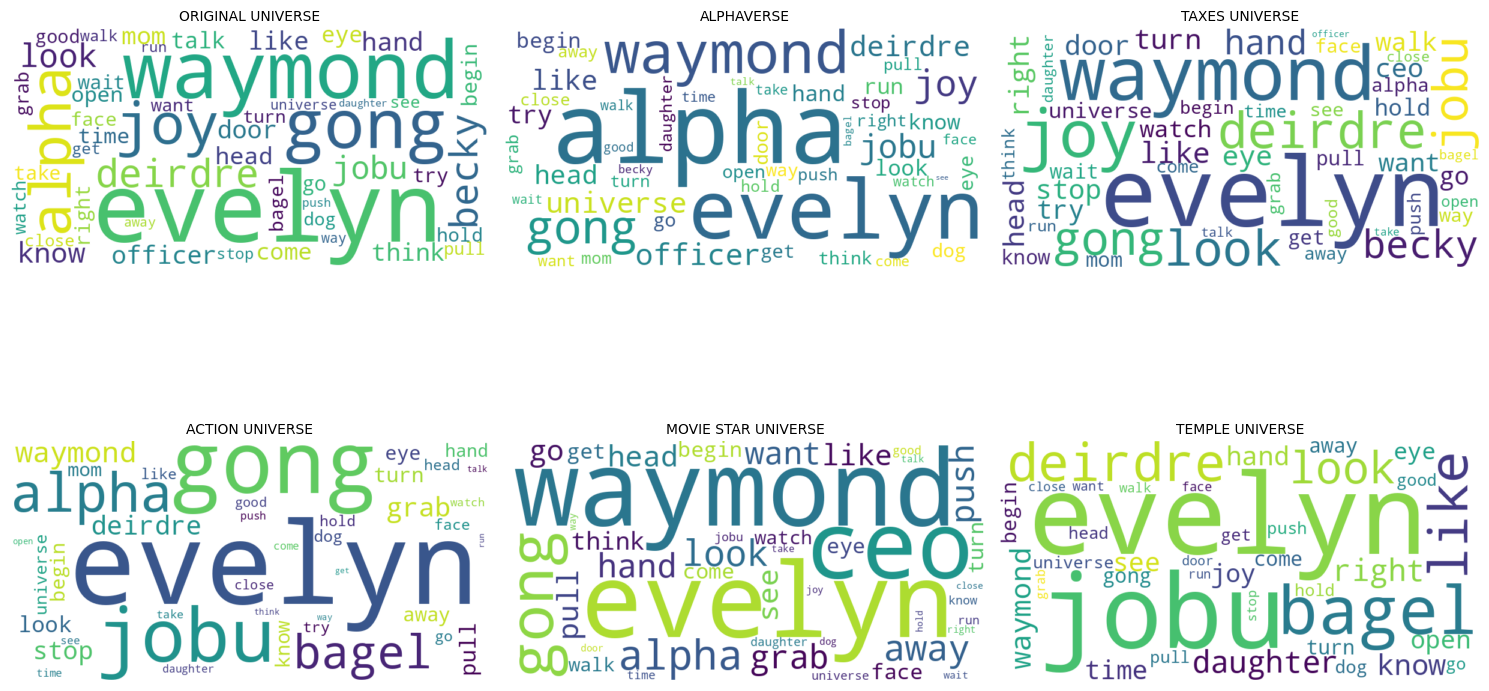

In [55]:
from wordcloud import WordCloud

def wordCloud(uni_content, type):
  # Create subplots
  fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust figsize
  axes = axes.flatten()  # Flatten for easy indexing


  if type == "dynamic":
    for universe in uni_content.index:
      word_scores = tfidf_df.loc[universe].sort_values(ascending=False).head(10).to_dict()
      fig = px.treemap(
        names=list(word_scores.keys()),
        parents=[""] * len(word_scores),
        values=list(word_scores.values()),
        title=f"Word Cloud for {universe}",
      )
    fig.show()


  else:
    # Generate word clouds for each universe
    for i, universe in enumerate(uni_content.index):
      # Prepare word frequencies for the universe
      word_scores = tfidf_df.loc[universe].to_dict()  # Replace with actual TF-IDF DataFrame

      # Create the word cloud
      wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

      # Display in the corresponding subplot
      axes[i].imshow(wordcloud, interpolation='bilinear')
      axes[i].axis('off')  # Hide axes
      axes[i].set_title(universe, fontsize=10)

    # Hide unused subplots (if universes < rows * cols)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

wordCloud(uni_content, "normal")

Select the top 15 words with highest TF-IDF score in the script, and visualize them on heat map to compare their significance across universe

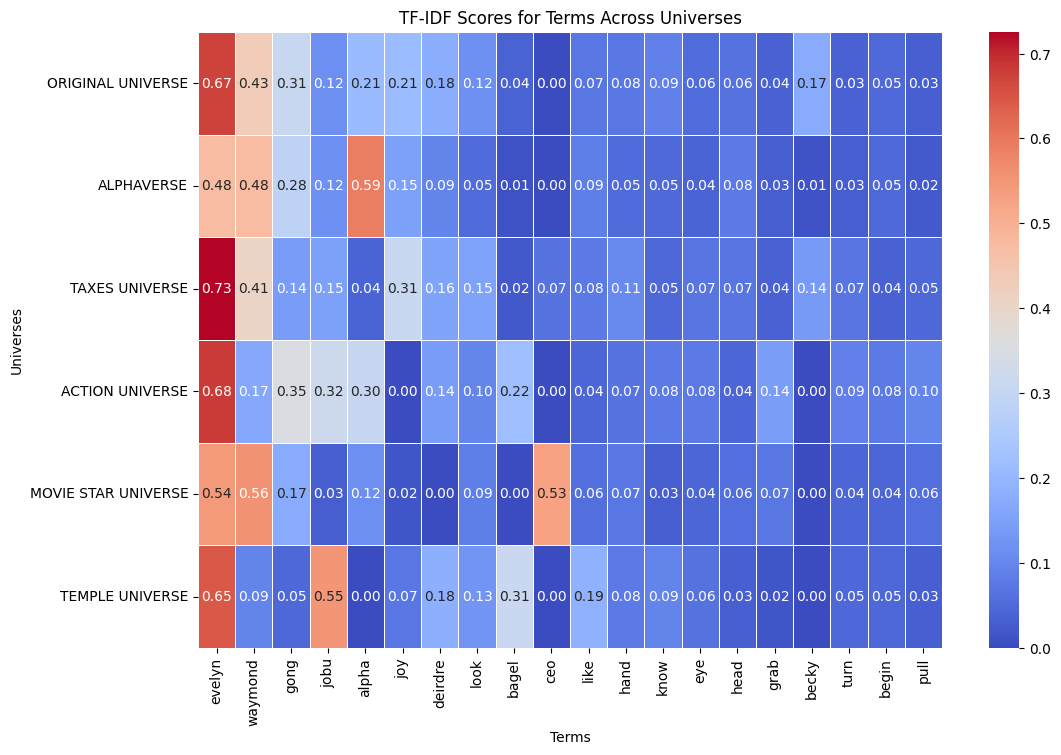

In [57]:


# Sum TF-IDF scores across all universes
global_top_words = tfidf_df.sum(axis=0).sort_values(ascending=False).head(20).index

# Filter TF-IDF DataFrame
filtered_tfidf_df = tfidf_df[global_top_words]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_tfidf_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('TF-IDF Scores for Terms Across Universes')
plt.xlabel('Terms')
plt.ylabel('Universes')
plt.show()

We can see that characters take on different importance depending on the universe. While Evelyn stays the protagonist, her presence is relatively less prominent in Alphaverse and Movie Star Universe, where Waymond has a similar significance as her. "ceo" also appears in Movie Star Universe, as Waymond's identity in Evelyn’s alternate life of success. Jobu is most prominent in Temple Universe, which mainly focuses on her interaction with Evelyne. "alpha" is prominent in Alphaverse, the central hub of the multiverse, where Alpha Waymond introduces Evelyn to the concept of multiverse jumping. Verbs like "grab", "turn", and "pull" are most seen in Action Universe, showing the high action intensity. "Bagel,"  representing Jobu's nihilistic philosophy, is most seen in Temple and Action universe

#### Bigram analysis
remove character names for thematic words

In [58]:
# TF-IDF: bigram - remove character names
tfidf_df = tfIdf(uni_content,2,1)
scenes = tfidf_df.index

cols = 3
rows = 2

# Create subplots
fig = make_subplots(rows=rows, cols=cols, subplot_titles=uni_content.index)

# Add bar charts to subplots
for i, universe in enumerate(uni_content.index):
    row, col = divmod(i, cols)  # Determine row and column
    top_terms = tfidf_df.loc[universe].sort_values(ascending=False).head(10)
    fig.add_trace(
        go.Bar(x=top_terms.index, y=top_terms.values, name=universe),
        row=row + 1, col=col + 1
    )

# Update layout
fig.update_layout(height=800, width=1400, title_text="TF-IDF Comparison Across Universes", showlegend=False)
fig.show()

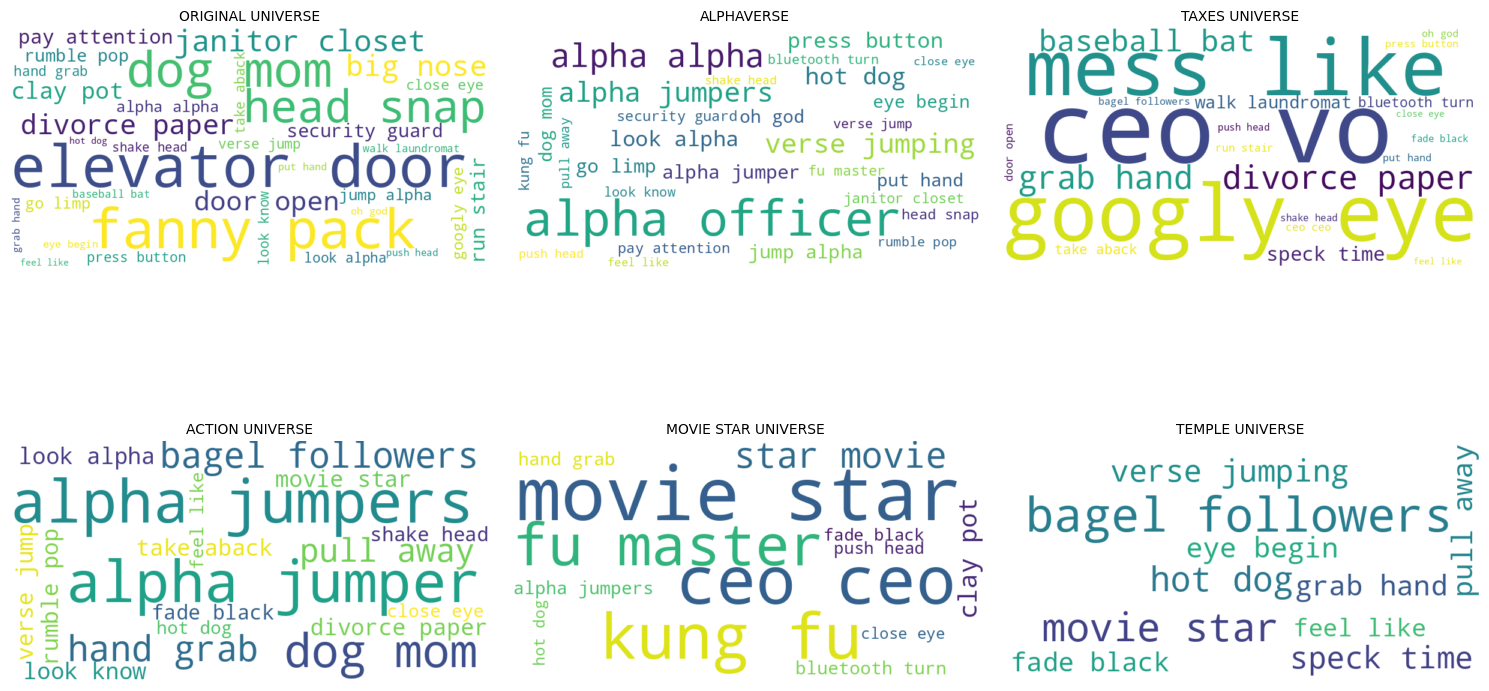

In [59]:
wordCloud(uni_content, "normal")

The bigram analysis across the six universes provides deeper insights into the specific actions, objects, and themes that define each universe. For Movie Star Universe, terms like "movie star" and "kung fu" reflect Evelyn’s alternate life as a glamorous, successful martial artist. This universe contrasts sharply with the Original and Taxes Universes, which have mundane, everyday settings, like "elevator door" "fanny pack" "divorce paper". Action universe and alphaverse are dominated by terms like "alpha jumpers" "verse jump," focusing on the chaotic multiverse action.
